**Libraries**

In [17]:

import pandas as pd          # Data handling
import numpy as np           # Numerical operations

# Preprocessing & splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Machine Learning model
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [6]:
df = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

# Display dataset shape and first few rows
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (40064, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


**Data Cleaning**

In [27]:
# -------------------------------
# Step 3 (Fix): Data Cleaning & Preprocessing
# -------------------------------

# Ensure column names have no spaces
df.columns = df.columns.str.strip()

# Drop non-numeric / ID columns
drop_cols = ["Flow ID", "Source IP", "Destination IP", "Timestamp"]
df = df.drop(columns=drop_cols, errors='ignore')

# Replace inf/-inf with NaN and drop missing values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print("Dataset shape after cleaning:", df.shape)

# ✅ Now 'Label' should exist properly
print("Columns available:", df.columns[-10:])  # show last 10 columns for check

# Separate features and target
X = df.drop("Label", axis=1)
y = df["Label"]

# Encode labels
from sklearn.preprocessing import LabelEncoder, StandardScaler
le = LabelEncoder()
y = le.fit_transform(y)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features shape:", X_scaled.shape)
print("Labels shape:", y.shape)


Dataset shape after cleaning: (40050, 81)
Columns available: Index(['min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label'],
      dtype='object')
Features shape: (40050, 80)
Labels shape: (40050,)


**Train-test split (80/20)**

In [8]:
# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 32040
Testing set size: 8010


**Training**

In [9]:
# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=100,   # number of trees
    random_state=42,    # reproducibility
    n_jobs=-1           # use all CPU cores for speed
)

# Train the model
rf.fit(X_train, y_train)

print("Random Forest training complete")


Random Forest training complete


Prediction and Evaluation

In [10]:
# Make predictions
y_pred = rf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {acc*100:.2f}%\n")

# Class distribution
print("Class distribution in dataset:")
print(df["Label"].value_counts(), "\n")

# Classification Report (Precision, Recall, F1)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


✅ Model Accuracy: 99.94%

Class distribution in dataset:
Label
BENIGN    22792
DDoS      17258
Name: count, dtype: int64 

Classification Report:

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      4558
        DDoS       1.00      1.00      1.00      3452

    accuracy                           1.00      8010
   macro avg       1.00      1.00      1.00      8010
weighted avg       1.00      1.00      1.00      8010



**Confusion Matrix Visualization**

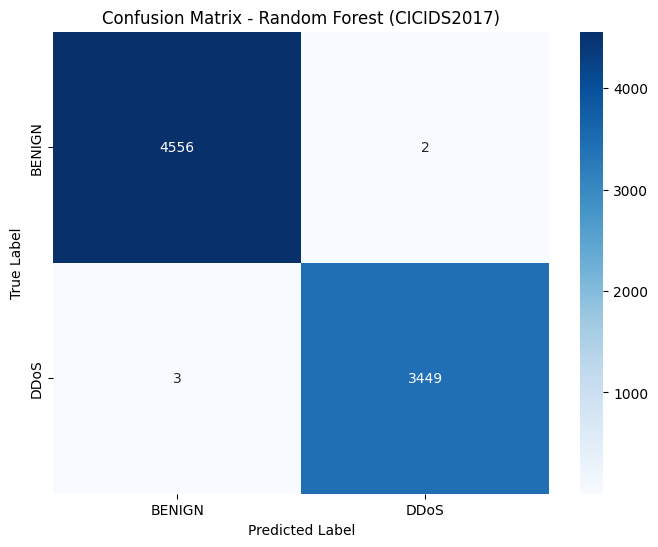

In [11]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest (CICIDS2017)")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**XG BOOST**

In [1]:
# ==============================
# Step 1: Import XGBoost
# ==============================

import xgboost as xgb


**Initialize the Model**

In [2]:
# Create an XGBoost Classifier instance
# n_estimators = number of decision trees
# For demonstration, we use 10 (fast execution), but in real projects use higher (100–500+)
xg = xgb.XGBClassifier(n_estimators=10)

**Train the Model**

In [22]:
# Train model on training data
xg.fit(X_train, y_train)
print("XG boost training complete")

XG boost training complete


**Accuracy Evaluation**

In [13]:
# Evaluate accuracy on the test dataset
xg_score = xg.score(X_test, y_test)
print("Accuracy of XGBoost: " + str(xg_score))

Accuracy of XGBoost: 0.9992509363295881


**Predictions**

In [14]:
# Predict test labels
y_predict = xg.predict(X_test)

# Store true labels
y_true = y_test

**Precision, Recall, F1-score**

In [18]:
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_true, y_predict, average='weighted'
)

print("Precision of XGBoost: " + str(precision))
print("Recall of XGBoost: " + str(recall))
print("F1-score of XGBoost: " + str(fscore))

# Detailed metrics per class
print(classification_report(y_true, y_predict))

Precision of XGBoost: 0.9992509363295881
Recall of XGBoost: 0.9992509363295881
F1-score of XGBoost: 0.9992509363295881
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4558
           1       1.00      1.00      1.00      3452

    accuracy                           1.00      8010
   macro avg       1.00      1.00      1.00      8010
weighted avg       1.00      1.00      1.00      8010



**Confusion Matrix**

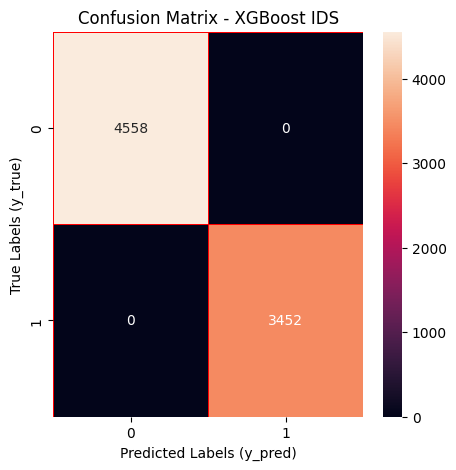

In [37]:
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("Predicted Labels (y_pred)")
plt.ylabel("True Labels (y_true)")
plt.title("Confusion Matrix - XGBoost IDS")
plt.show()

---------------------------------------------------------------------------------------------------------------


**LightGBM**

**LIBRARIES**

In [28]:
# Import only LightGBM
import lightgbm as lgb


**Train LightGBM Model**

In [36]:
# Define LightGBM classifier with silent mode enabled
lgb_clf = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=64,
    objective='binary',
    random_state=42,
    verbosity=-1   # <- this suppresses internal logs
)

# Train the model (no verbose param needed here)
lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[lgb.log_evaluation(0)]  # <- disables eval logging
)
print("LightGBM training complete")

LightGBM training complete


**Evaluate Model**

Accuracy of LightGBM: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4558
           1       1.00      1.00      1.00      3452

    accuracy                           1.00      8010
   macro avg       1.00      1.00      1.00      8010
weighted avg       1.00      1.00      1.00      8010



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


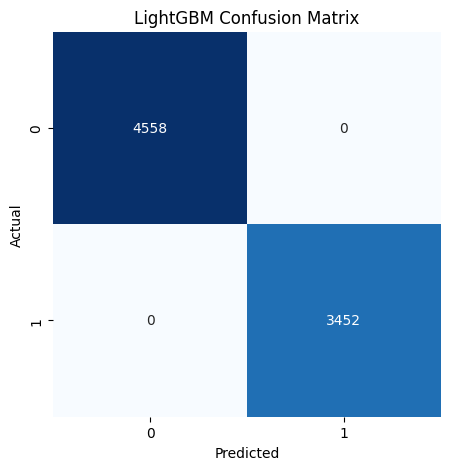

In [35]:
# Predictions
y_pred = lgb_clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy of LightGBM: {acc:.2f}%")

# Precision, Recall, F1
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {fscore * 100:.2f}%")

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LightGBM Confusion Matrix")
plt.show()
